In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy as fp

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


In [2]:
name = 'R1DR2_2'
exe_name = '../../mf6'

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name=name, exe_name=exe_name)

# create tdis package
tdis = fp.mf6.ModflowTdis(sim)

# create iterative model solution
ims = fp.mf6.ModflowIms(sim, complexity='moderate')

# Create the gwf model object 
gwf = fp.mf6.ModflowGwf(sim, modelname=name)

In [4]:
nlay, nrow, ncol = 3, 451, 450
delr = delc = 5.71
msize = (nlay, nrow, ncol)
botm = [66.67, 33.33, 0]

(451, 450)


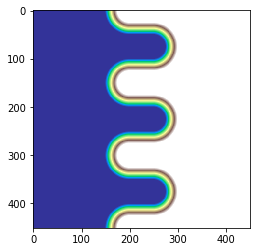

In [5]:
fpth = 'headlands.txt'
top = np.loadtxt(fpth, dtype=np.float)
print (top.shape)

plt.imshow(top,cmap=plt.cm.terrain)

In [6]:
fpth = 'ibnd1.txt'
ibnd1 = np.loadtxt(fpth, dtype=np.int)
fpth = 'ibnd2.txt'
ibnd2 = np.loadtxt(fpth, dtype=np.int)
fpth = 'ibnd3.txt'
ibnd3 = np.loadtxt(fpth, dtype=np.int)

idomain = np.concatenate((ibnd1,ibnd2,ibnd3))
idomain = idomain.reshape(nlay,nrow,ncol)
idomain.shape

(3, 451, 450)

In [8]:
# Create the discretization package 
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm, 
                              idomain=idomain)

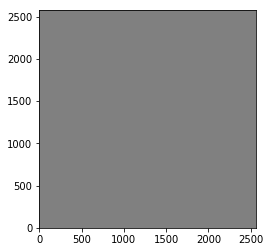

In [9]:
#mm = fp.plot.PlotMapView(model=gwf)
#mm.plot_grid()

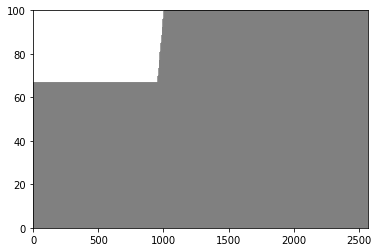

In [10]:
xs = fp.plot.PlotCrossSection(model=gwf, line={'row': 10})
xs.plot_grid()

In [11]:
# Create the initial conditions (IC) package
ic = fp.mf6.ModflowGwfic(gwf, strt=70.)

In [12]:
# Create the node property flow (NPF) package
kh = [1e-5, 1e-5, 1e-5]
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, k=kh)

In [13]:
recharge = 1.0e-8
# Create the recharge package
rch = fp.mf6.ModflowGwfrcha(gwf, recharge=recharge, print_input=True)

In [14]:
# Create drain package
fpth = 'R1DR2_2_DRN.txt'
drains = np.loadtxt(fpth)
drains[0]
drn_spd = [[tuple((int(i[0]-1), int(i[1]-1), int(i[2]-1))), i[3], i[4]] for i in drains]
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_spd)

In [15]:
# Build output control
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
oc = fp.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                            head_filerecord=hname,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [16]:
gwf.name_file.save_flows = True

In [17]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model R1DR2_2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 24799 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: ../../mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 13 2019 12:37:09 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analy

(True, [])

In [19]:
hobj = fp.utils.HeadFile(hname)
hds = hobj.get_data()

In [23]:
cobj = fp.utils.CellBudgetFile(cname, precision=hobj.precision)
cobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
DRN                  6
RCH                  6


In [24]:
spd = cobj.get_data(text='DATA-SPDIS')[0]

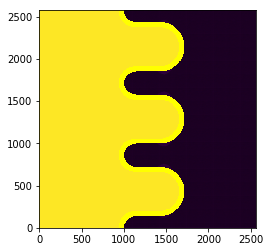

In [25]:
mm = fp.plot.PlotMapView(model=gwf, layer=0)
mm.plot_array(hds)
mm.plot_specific_discharge(spd)
mm.plot_bc('DRN')

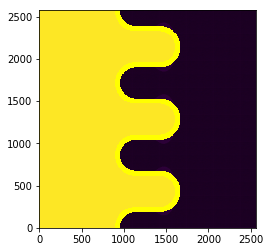

In [26]:
mm = fp.plot.PlotMapView(model=gwf, layer=1)
mm.plot_array(hds)
mm.plot_specific_discharge(spd)
mm.plot_bc('DRN')